# Essay

Aplikasikan `Logistic Regression` pada data diabetes dan aplikasikan `Decision Trees` pada data iris.

## Import Library yang dibutuhkan

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes, load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## Implementasi `Logistic Regression`

### Load dataset

In [2]:
diabetes = load_diabetes(as_frame=True)
# Menampilkan dataset's keys
print(list(diabetes))

['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module']


Untuk mendapatkan informasi kolom-kolom apa yang ada pada data tersebut kita bisa menggunakan perintah `print(diabetes['DESCR'])`

In [3]:
print(diabetes['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Kita ambil data tersebut yang merupakan sebuah `Pandas DataFrame` dan merubah nama kolom sesuai deskripsi.

In [4]:
# Load and rename the columns
diabetes_features_df = diabetes['data'].rename(columns={
    's1': 'tc',
    's2': 'ldl',
    's3': 'hdl',
    's4': 'tch',
    's5': 'ltg',
    's6': 'glu'
})

# Show only top 10 rows
diabetes_features_df.head(10)

,age,sex,bmi,bp,tc,ldl,hdl,tch,ltg,glu
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641
5,-0.092695,-0.044642,-0.040696,-0.019442,-0.068991,-0.079288,0.041277,-0.076395,-0.041180,-0.096346
6,-0.045472,0.050680,-0.047163,-0.015999,-0.040096,-0.024800,0.000779,-0.039493,-0.062913,-0.038357
7,0.063504,0.050680,-0.001895,0.066630,0.090620,0.108914,0.022869,0.017703,-0.035817,0.003064
8,0.041708,0.050680,0.061696,-0.040099,-0.013953,0.006202,-0.028674,-0.002592,-0.014956,0.011349
9,-0.070900,-0.044642,0.039062,-0.033214,-0.012577,-0.034508,-0.024993,-0.002592,0.067736,-0.013504


Mengambil `target` dan menggabungkannya dengan `diabetes_features_df`.

In [5]:
# Load target
diabetes_target_df = pd.DataFrame({'target_progression': diabetes['target']})
diabetes_target_df.head(10)

,target_progression
0,151.0
1,75.0
2,141.0
3,206.0
4,135.0
5,97.0
6,138.0
7,63.0
8,110.0
9,310.0


Berdasarkan informasi pada link berikut ini:
http://p2ptm.kemkes.go.id/infographic-p2ptm/penyakit-diabetes-melitus/page/5/yuk-mengenal-apa-itu-penyakit-diabetes-melitus-dm bahwa batas normal seseorang tidak mengalami diabetes < 200, lebih dari itu diabetes. Maka dari itu, kita perlu kategorisasi.

In [6]:
def kategori_diabetes(value):
  if value < 200:
    return 0
  else:
    return 1

In [7]:
# Load target
diabetes_target_df['target_category'] = diabetes_target_df['target_progression'].apply(lambda val: kategori_diabetes(val))

# Merge two dfs into single df
diabetes_df = pd.merge(diabetes_features_df, diabetes_target_df, left_index=True, right_index=True)
diabetes_df.head(10)

,age,sex,bmi,bp,tc,ldl,hdl,tch,ltg,glu,target_progression,target_category
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0,0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0,0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0,0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0,1
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0,0
5,-0.092695,-0.044642,-0.040696,-0.019442,-0.068991,-0.079288,0.041277,-0.076395,-0.041180,-0.096346,97.0,0
6,-0.045472,0.050680,-0.047163,-0.015999,-0.040096,-0.024800,0.000779,-0.039493,-0.062913,-0.038357,138.0,0
7,0.063504,0.050680,-0.001895,0.066630,0.090620,0.108914,0.022869,0.017703,-0.035817,0.003064,63.0,0
8,0.041708,0.050680,0.061696,-0.040099,-0.013953,0.006202,-0.028674,-0.002592,-0.014956,0.011349,110.0,0
9,-0.070900,-0.044642,0.039062,-0.033214,-0.012577,-0.034508,-0.024993,-0.002592,0.067736,-0.013504,310.0,1


### Exploratory data analysis

Berapa banyak yang berkategori 1=diabetes, dan 0=tidak

0    315
1    127
Name: target_category, dtype: int64


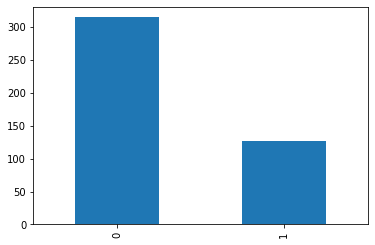

In [8]:
# How many 
diabetes_df.target_category.value_counts().plot.bar()
print(diabetes_df.target_category.value_counts())

### Data spliting

Mendefinisikan X dan y

In [9]:
X = diabetes_df.drop(['target_progression', 'target_category'], axis=1).values
y = diabetes_df.target_category.values

X.shape, y.shape

((442, 10), (442,))

In [10]:
# Check data types
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

Karena data sudah distandardisasi oleh Scikit learn, sehingga tidak perlu lagi untuk distandardisasi. Selanjutnya adalah melakukan split data untuk training dan testing. Misalkan kita akan split data training dan testing 80:20

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((331, 10), (111, 10), (331,), (111,))

### Data training dan testing

In [12]:
# Building model
diabetes_model = LogisticRegression()
diabetes_model.fit(X_train, y_train)
print(diabetes_model.score(X_train, y_train))

0.7190332326283988


In [13]:
# Predicting data from X_test
y_diabetes_prediction = diabetes_model.predict(X_test)
print("Predicted Output Values")
print(y_diabetes_prediction)

Predicted Output Values
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [14]:
diabetes_model_score = diabetes_model.score(X_test, y_test)
print(diabetes_model_score)
print(confusion_matrix(y_test, y_diabetes_prediction))

0.7477477477477478
[[82  0]
 [28  1]]


## Implementasi `Decision Trees`

Menggunakan cara lain untuk load dataset dari Scikitlearn

### Load dataset

In [15]:
X, y = load_iris(return_X_y=True)
X.shape, y.shape

((150, 4), (150,))

### Data spliting

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((112, 4), (38, 4), (112,), (38,))

### Data training dan testing

In [17]:
# Creating Decision Tree Classifier
iris_model = DecisionTreeClassifier()
iris_model.fit(X_train, y_train)
print(iris_model.score(X_train, y_train))

1.0


In [18]:
# Predicting data from X_test
y_iris_prediction = iris_model.predict(X_test)
print("Predicted Output Values")
print(y_iris_prediction)

Predicted Output Values
[0 1 1 0 2 1 2 0 0 2 1 0 2 1 1 0 1 1 0 0 1 1 2 0 2 1 0 0 1 2 1 2 1 2 2 0 1
 0]


In [19]:
iris_model_score = iris_model.score(X_test, y_test)
print(iris_model_score)
print(confusion_matrix(y_test, y_iris_prediction))

0.9736842105263158
[[13  0  0]
 [ 0 15  1]
 [ 0  0  9]]
